In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
random_seed = 42
np.random.seed(random_seed)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [11]:
# Load the data
train = pd.read_csv("./input/mnist/train.csv")
test = pd.read_csv("./input/mnist/test.csv")

In [12]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [13]:
Y_train = train.label
X_train = train.drop(labels = ['label'], axis = 1 )

In [14]:
round(Y_train.value_counts() / sum(Y_train.value_counts() ) * 100 ,2)

1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

In [15]:
X_train.isnull().sum().any()

False

### Data Normalization 

In [16]:
X_train = X_train / 255.0
test = test / 255.0

### Tensors preparation

In [17]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = test.values.reshape(-1,28,28,1)

### One hot encoding 

In [18]:
Y_train_cat = pd.get_dummies(Y_train)

### Training and validation sets 

In [68]:
X_tr , X_val , Y_tr , Y_val  = train_test_split(X_train, Y_train_cat , test_size = 0.0, random_state=random_seed )

In [75]:
X_val

array([], shape=(0, 28, 28, 1), dtype=float64)

## The model 

In [69]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [70]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [71]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## Learning rate 

In [72]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [74]:
epochs = 15 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 172

In [ ]:
m1 = model.fit(X_tr, Y_tr, batch_size = batch_size, epochs = epochs)
#,  validation_data = (X_val, Y_val), verbose = 1

Epoch 1/15
42000/42000 [==============================] - 331s 8ms/step - loss: 0.2316 - acc: 0.9261
Epoch 2/15
42000/42000 [==============================] - 336s 8ms/step - loss: 0.0772 - acc: 0.9770
Epoch 3/15
30100/42000 [====================>.........] - ETA: 1:25 - loss: 0.0577 - acc: 0.9829

### Confusion matrix 

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

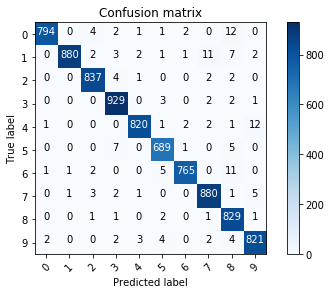

In [27]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax( np.array(Y_val) ,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

### Some False predictions 

In [29]:
errors = list(Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = np.array(Y_val)[errors]
X_val_errors = X_val[errors]

In [30]:
error = []
for i in range(len(Y_true_errors)): 
    mse = mean_squared_error(Y_pred_errors[i, : ],Y_true_errors[i, : ] ) 
    error.append(mse)

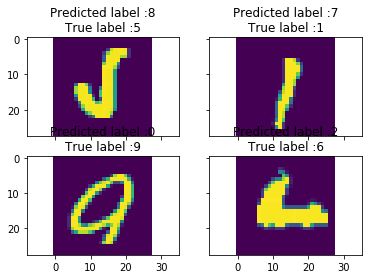

In [35]:
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
nb = 0 
for i in range(0,2):
    for j in range(0,2):
        nb+=1
        ax[i ,j].imshow((X_val_errors[-nb]).reshape((28,28)))
        ax[i,j].set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_classes_errors[-nb], np.argmax(Y_true_errors[-nb] )))



### Predictions

In [62]:
Pred = model.predict_classes(X_test)

In [58]:
results = pd.Series(Pred,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

In [63]:
nb = 0 
for i in range(0,2):
    for j in range(0,2):
        nb+=1
        ax[i,j].imshow((X_test[nb-1].reshape((28,28))))
        ax[i,j].set_title("Predicted label :{}".format(Pred[nb-1] ))

In [65]:
display(submission.head())
submission.to_csv("cnn_mnist.csv",index=False)


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
